In [277]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit


plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.labelspacing'] = 0.3
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["xtick.major.size"]=5
plt.rcParams["xtick.minor.size"]=3
plt.rcParams["ytick.major.size"]=5
plt.rcParams["ytick.minor.size"]=3

# 1. Input parameters

In [55]:
pipet_diameter = 7.5
vesicle_diameter = 34.588
first_frame_vesicle_in_image = 1
t_interval = 0.133 # in sec
pressure_interval = 50 # Pa/sec

Rp = pipet_diameter/2 #in micron
Ro = vesicle_diameter/2 #in micron
raw_data = pd.read_csv('Results.csv')

# 2. Organize and visualize raw data

In [56]:

#test_set = [5*i for i in range(15)]
#raw_data = raw_data.iloc[test_set]
raw_data.columns = ['frame_number', 'area', 'mean', 'std', 'x_center', 'y_center', 'bx', 'by', 'width', 'height'] # put title into lowercases

raw_data['frame_number'] = raw_data.frame_number + first_frame_vesicle_in_image
raw_data['time'] = raw_data.frame_number * t_interval
raw_data['tongue_length'] = raw_data.bx + raw_data.width
raw_data['areal_expansion'] = ((Rp/Ro)**2 - (Rp/Ro)**3)*raw_data.tongue_length/2/Rp
raw_data['pressure'] = raw_data.time * pressure_interval
raw_data['membrane_tension'] = Rp/2/(1-Rp/Ro)*raw_data.pressure/1000

raw_data

,frame_number,area,mean,std,x_center,y_center,bx,by,width,height,time,tongue_length,areal_expansion,pressure,membrane_tension
0,2,14.709,56.204,15.655,0.696,7.140,0,0.709,1.985,13.041,0.266,1.985,0.009746,13.30,0.031842
1,3,30.643,49.275,13.951,1.765,7.073,0,0.567,4.394,12.474,0.399,4.394,0.021574,19.95,0.047763
2,4,38.098,45.141,15.152,2.112,7.189,0,0.709,5.245,13.183,0.532,5.245,0.025752,26.60,0.063684
3,5,38.098,43.356,16.063,2.152,7.043,0,0.709,5.245,12.191,0.665,5.245,0.025752,33.25,0.079605
4,6,39.284,46.135,16.270,2.205,7.052,0,0.709,5.528,12.616,0.798,5.528,0.027141,39.90,0.095526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,208,35.426,46.618,9.907,4.432,6.948,0,2.268,8.930,9.214,27.664,8.930,0.043844,1383.20,3.311576
207,209,38.721,45.002,9.867,4.278,6.968,0,2.268,8.789,9.072,27.797,8.789,0.043152,1389.85,3.327497
208,210,34.562,46.030,9.447,4.211,7.029,0,2.410,8.789,9.072,27.930,8.789,0.043152,1396.50,3.343418
209,211,33.818,47.077,10.466,4.418,7.047,0,2.552,8.930,8.789,28.063,8.930,0.043844,1403.15,3.359339


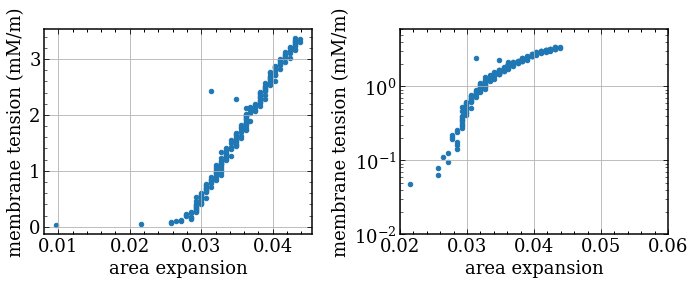

In [282]:
fig, axes = plt.subplots(1,2, figsize = (10,4))
axes.flatten()
raw_data.plot(x = 'areal_expansion', y = 'membrane_tension', kind = 'scatter', ax = axes[0])
axes[0].set_xlabel('area expansion')
axes[0].set_ylabel('membrane tension (mM/m)')
axes[0].grid()

raw_data.plot(x = 'areal_expansion', y = 'membrane_tension', kind = 'scatter', ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('area expansion')
axes[1].set_xlim(left = 0.02,right = 0.06)
axes[1].set_ylim(bottom = 0.01,top = 6)
axes[1].set_ylabel('membrane tension (mM/m)')
axes[1].grid()

plt.tight_layout();

# 3. Fitting stretching modulus

In [260]:
condition_stretch = raw_data['membrane_tension'] > 1
#condition_stretch_else = raw_data['membrane_tension'] <= 1

condition_stretch_else = ~condition_stretch

In [261]:
x_stretch = raw_data[condition_stretch][['areal_expansion']]
y_stretch = raw_data[condition_stretch]['membrane_tension']
x_stretch_else = raw_data[condition_stretch_else][['areal_expansion']]
y_stretch_else = raw_data[condition_stretch_else]['membrane_tension']

In [262]:
# plt.scatter(x_stretch, y_stretch, alpha = 0.5, label = 'stretch')
# plt.scatter(x_stretch_else, y_stretch_else, alpha = 0.5, label = 'else')
# plt.xlabel('Areal Strain')
# plt.ylabel('Membrane Tension')
# plt.legend();

In [263]:
from sklearn.linear_model import LinearRegression

In [264]:
lr_stretch = LinearRegression().fit(x_stretch,y_stretch)

lr_stretch.intercept_, lr_stretch.coef_

(-5.321145246794732, array([199.61296531]))

In [265]:
#Calculate mean squared error
from sklearn.metrics import mean_squared_error

In [266]:
y_stretch_pred = lr_stretch.predict(x_stretch)

mean_squared_error(y_stretch, y_stretch_pred)

0.025066022373403125

In [267]:
# Calculate r^2
from sklearn.metrics import r2_score

r2_score(y_stretch, y_stretch_pred)

0.9472575136068979

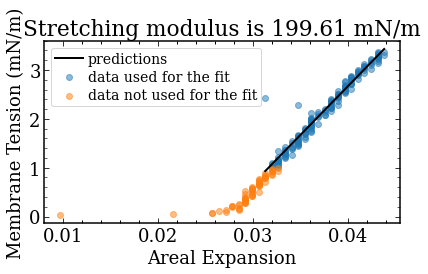

In [307]:
# Plot fitting result
lin_x_stretch = np.linspace(x_stretch.min(), x_stretch.max(), 1000)
lin_y_stretch = lr_stretch.predict(lin_x)

plt.plot(lin_x_stretch, lin_y_stretch, 'k-', label = 'predictions' );
plt.scatter(x_stretch, y_stretch, alpha = 0.5, label = 'data used for the fit')
plt.scatter(x_stretch_else, y_stretch_else, alpha = 0.5, label = 'data not used for the fit')
plt.xlabel('Areal Expansion')
plt.ylabel('Membrane Tension (mN/m)')
plt.title(f'Stretching modulus is {lr_stretch.coef_[0]:.2f} mN/m')
plt.legend()
plt.tight_layout();

# 4. Fitting bending stiffness

In [291]:
condition_bend = (raw_data['membrane_tension'] < 0.5) & (raw_data.index > 1)
condition_bend_else = ~condition_bend

In [292]:
x_bend = raw_data[condition_bend][['areal_expansion']]
y_bend = np.log(raw_data[condition_bend]['membrane_tension'])

x_bend_else = raw_data[condition_bend_else][['areal_expansion']]
y_bend_else = np.log(raw_data[condition_bend_else]['membrane_tension'])

x_bend.shape, y_bend.shape

((28, 1), (28,))

In [293]:
# plt.scatter(x_bend, y_bend, alpha = 0.5, label = ('bend'))
# plt.scatter(x_bend_else, y_bend_else, alpha = 0.5, label = ('else'))
# plt.xlabel('temp')
# plt.ylabel('count')
# plt.legend();

In [294]:
lr_bend = LinearRegression().fit(x_bend,y_bend)

lr_bend.intercept_, lr_bend.coef_

(-14.180716001724464, array([446.58331032]))

In [295]:
# Calculate mean square error
y_bend_pred = lr_bend.predict(x_bend)

mean_squared_error(x_bend, y_bend_pred)

2.365342279442595

In [296]:
# Calculate r_square of the fit
r2_score(y_bend_pred, y_bend)

0.8675729773649041

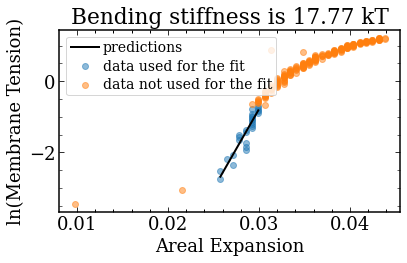

In [308]:
# Plot fitting results

lin_x_bend = np.linspace(x_bend.min(), x_bend.max(), 1000)
lin_y_bend = lr_bend.predict(lin_x_bend)

plt.plot(lin_x_bend, lin_y_bend, 'k-', label = 'predictions' );
plt.scatter(x_bend, y_bend, alpha = 0.5, label = ('data used for the fit'))
plt.scatter(x_bend_else, y_bend_else, alpha = 0.5, label = ('data not used for the fit'))
plt.xlabel('Areal Expansion')
plt.ylabel('ln(Membrane Tension)')
plt.title(f'Bending stiffness is {lr_bend.coef_[0]/8/np.pi:.2f} kT')
plt.legend()
plt.tight_layout();

# 5. Plot both graphs

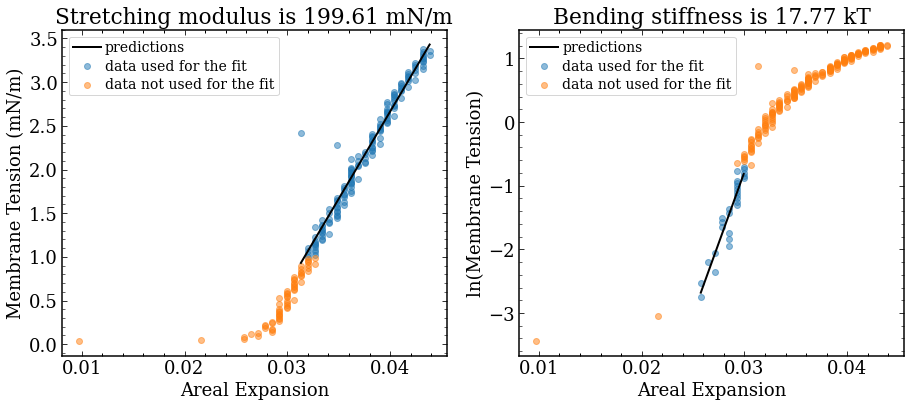

In [314]:
fig, axes = plt.subplots(1,2, figsize = (13,6))
axes.flatten()


axes[0].plot(lin_x_stretch, lin_y_stretch, 'k-', label = 'predictions' );
axes[0].scatter(x_stretch, y_stretch, alpha = 0.5, label = 'data used for the fit')
axes[0].scatter(x_stretch_else, y_stretch_else, alpha = 0.5, label = 'data not used for the fit')
axes[0].set_xlabel('Areal Expansion')
axes[0].set_ylabel('Membrane Tension (mN/m)')
axes[0].set_title(f'Stretching modulus is {lr_stretch.coef_[0]:.2f} mN/m')
axes[0].legend(loc = 'best')
axes[0].grid()

axes[1].plot(lin_x_bend, lin_y_bend, 'k-', label = 'predictions' );
axes[1].scatter(x_bend, y_bend, alpha = 0.5, label = ('data used for the fit'))
axes[1].scatter(x_bend_else, y_bend_else, alpha = 0.5, label = ('data not used for the fit'))
axes[1].set_xlabel('Areal Expansion')
axes[1].set_ylabel('ln(Membrane Tension)')
axes[1].set_title(f'Bending stiffness is {lr_bend.coef_[0]/8/np.pi:.2f} kT')
axes[1].legend(loc = 'best')
axes[0].grid()

plt.tight_layout();
